In [1]:
#@title Imports 
import numpy as np, pandas as pd, matplotlib.pyplot as plt, matplotlib as mpl
import tjy_udf as tjy
print("tjy_udf: ", list(filter(lambda x: '__' not in x, dir(tjy)))) # Print contained functions
mpl.rc_file('tjy.mplstyle')

pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', None)
DISPLAY_SORTED = True
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
from matplotlib import ticker
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)
from matplotlib import animation, rc
    
# GIT = 'https://github.com/tyokokur/tmpdat/raw/main/nfh/'
GIT = 'https://raw.githubusercontent.com/tyokokur/tmpdat/main/nfh/'

###COOLWARM COLORMAP DOCUMENTATION  
#https://depts.washington.edu/airqual/coolwarm.m
#Base blue: RGB = [59 76 192]
#Base red:  RGB = [180 4 38]
warm_red = [180/255, 4/255, 38/255]
cool_blue = [59/255,76/255,192/255]
mix_purp = np.divide(np.add(warm_red,cool_blue),2).tolist()

tjy_udf:  ['H_find', 'Kap_D', 'git_sync', 'lighten_color', 'plot_anim', 'plot_pha', 'ticks']


In [ ]:
## NFH
c1 = [122/255, 28/255, 188/255]
c2 = [252/255, 159/255, 128/255]

from datetime import datetime
labs =  ['004', '005', '006', '008', '010', '015', '020', '030', '040', '050']
labs =  ['003', '0035', '004', '005', '006', '008', '010', '015', '020', '030', '040', '050']
tack = [0]*len(labs) #see add for options
#tack[8:9] = [1]*2
#tack[10:] = [2]*6
add = ['', '_1C', '_']
read_list = ['phf400_c'+add[tack[ind]]+i+'.dat' for ind, i in enumerate(labs)]
print("Files:\n", read_list)
read_list = [GIT+i for i in read_list]
algs = ['thresh', 'maxpt', 'norm']

##########################################
##########################################
norms = [250, 55, 31.5]
thresh = 1e-04
##########################################
##########################################

algind = 2
print(algs[algind])
LH = np.zeros(len(read_list))
print("[", end="")
for i in range(len(read_list)): 
  LH[i] = tjy.H_find(read_list[i], alg=algs[algind], thresh=thresh)
  print(LH[i], end="")
  if i!=(len(read_list)-1): print(", ", end="")
print("]")
####################

SrCs = [float(i) for i in labs]
SrCs[1] = 3.5
Sr_equil = LH
Sr_equil = np.divide(Sr_equil,  norms[algind])
CsDeb = [1/tjy.Kap_D(i*1e-3)*1e9 for i in SrCs]
print(CsDeb)

#Sr2014 pH2.4 fitted in Illustrator
x = [4, 4.5, 5, 6, 15, 30, 55]
y = [1.3, 0.98, 0.68, 0.48, 0.38, 0.26, 0.12]
xDeb = [1/tjy.Kap_D(i*1e-3)*1e9 for i in x]

f, ax = plt.subplots(1,1)

# INSET
axins = ax.inset_axes([0.05, 0.52, 0.40, 0.40])
axins.plot(x, y, 'o', c=tjy.lighten_color('k', 0.60), mew=1.5, ms=7, markerfacecolor='w',label="  ")
axins.plot(SrCs[2:], Sr_equil[2:], '-', c=c2, lw=3, markerfacecolor='w', zorder=3, label="Our theory")


# # Paper format
ax.plot(xDeb, y, 'o', c=tjy.lighten_color('k', 0.60), mew=1.5, ms=7, markerfacecolor='w',label="  ")
ax.plot(CsDeb[2:], Sr_equil[2:], '-', c=c2, lw=3, markerfacecolor='w', zorder=3, label="Our theory")

# # PPT format
# ax.plot(xDeb, y, 'o-', c=tjy.lighten_color('k', 0.60), mew=1.5, ms=7, markerfacecolor='w',label="Exp from (2)")
# ax.plot(CsDeb, Sr_equil, 'o--', color=warm_red, mew=2, ms=12, markerfacecolor='w', zorder=3, label="Our theory")
# plt.gca().text(0.85, 0.95, 'Norm = {:.0f}'.format(norms[algind]), transform=plt.gca().transAxes, fontsize=18,
#        ha='center', va='center', bbox=dict(boxstyle='square', facecolor='none', edgecolor='none'))
# plt.gca().text(0.88, 0.02, '{}'.format(datetime.now().strftime("%m/%d/%Y, %H:%M")), transform=plt.gca().transAxes, fontsize=10,
#        ha='center', va='center', bbox=dict(boxstyle='square', facecolor='none', edgecolor='none'))

ax.set_title(r"")
ax.set_ylim(0, 1.5)
plt.yticks([0.0, 0.5, 1.0, 1.5])
plt.xticks([0, 1, 2, 3, 4, 5])
ax.set_xlim(0.5,5.7)

ax.set_xlabel(r'Screening Length $\mathbf{\kappa}_D^{-1}$'+' [nm]')
ax.set_ylabel('Normalized Height')
tjy.ticks()
    
## PLOT INSET#################################################
axins.set_xscale('log')
axins.set_xlim(3, 80)
axins.set_xticks([4, 6, 10, 20, 50])
axins.set_ylim(-0.1, 1.5)
axins.set_yticks([])
axins.set_xlabel(r'$I$')

class ScalarFormatterClass(ticker.ScalarFormatter):
   def _set_format(self):
      self.format = "$%d$" # New precision
axins.yaxis.set_major_formatter(ScalarFormatterClass(useMathText=True))
axins.xaxis.set_major_formatter(ScalarFormatterClass(useMathText=True))

# plt.savefig('./imgs/hprof.eps')
plt.show()

Files:
 ['phf400_c003.dat', 'phf400_c0035.dat', 'phf400_c004.dat', 'phf400_c005.dat', 'phf400_c006.dat', 'phf400_c008.dat', 'phf400_c010.dat', 'phf400_c015.dat', 'phf400_c020.dat', 'phf400_c030.dat', 'phf400_c040.dat', 'phf400_c050.dat']
norm
[39.10682895172387, 36.33618772314233, 32.88634733284891, 22.215158730320006, 

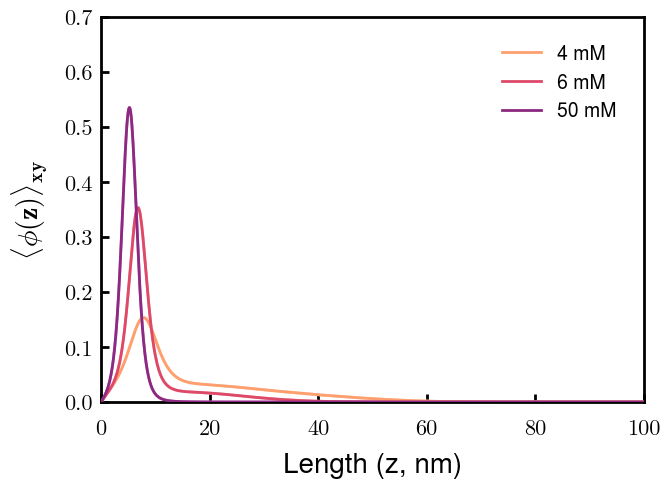

In [7]:
# labs = ['003', '0035', '004', '005', '006', '008', '010', '020', '050']
labs = ['004', '006', '050']
read_list = [GIT+"phf400_c"+i+".dat" for i in labs]
fig, axs = tjy.plot_pha(read_list, x1_end=100, x2_end=60, y1_end=0.70, y2_end=0.10, labs=['4 mM', '6 mM', '50 mM'], double=False,
                       colors = mpl.colormaps['magma'].resampled(11)(range(8,0,-2)).tolist())

In [12]:
for i in mpl.colormaps['magma'].resampled(11)(range(8,0,-2)).tolist():
    print([j*255 for j in i])

[253.65819, 159.20925, 108.98623500000001, 255.0]
[221.542215, 73.37064, 104.372265, 255.0]
[140.323185, 41.09529, 128.958345, 255.0]
[59.179635000000005, 15.271695, 111.612225, 255.0]


-2.1233204580143467e-05
2.916540313140262e-06
3.5544676986113636e-05
-0.0004282595470619637


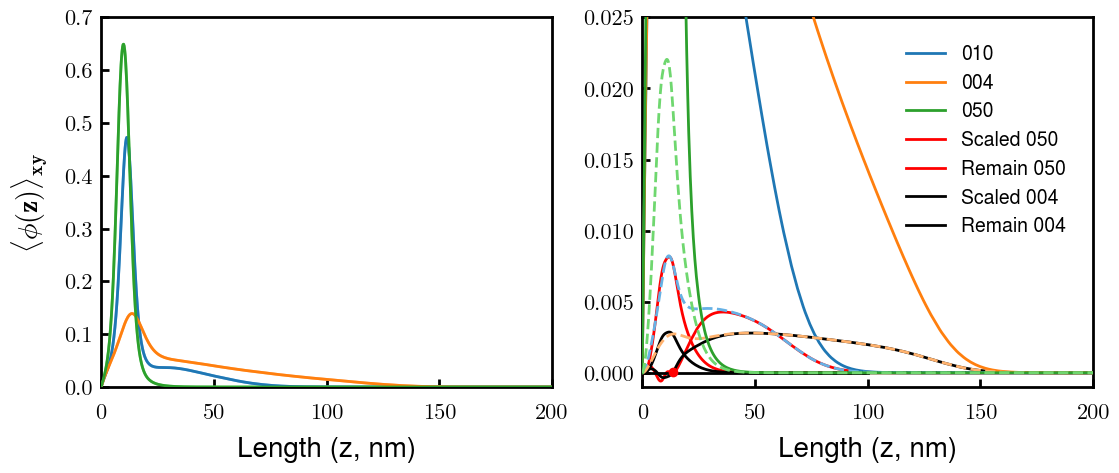

In [4]:
## Vol frac of condensed vs. coil
labs = ['010', '004', '050'] 
read_list = [GIT+"phb2v20_c"+i+".dat" for i in labs]
fig, axs = tjy.plot_pha(read_list, b0=2.0, x1_end=200, y1_end=0.7, y2_end=0.025, labs=labs, block2=4, double=True, show=False)

df0 = pd.read_csv(read_list[0], sep="\s+", skiprows=0, names=['lx','pha', '_2', '_3', '1', '2', '3', '4', 'end', '_9', 'phb'])
df1 = pd.read_csv(read_list[1], sep="\s+", skiprows=0, names=['lx','pha', '_2', '_3', '1', '2', '3', '4', 'end', '_9', 'phb'])
b = pd.read_csv(read_list[-1], sep="\s+", skiprows=0, names=['lx','pha', '_2', '_3', '1', '2', '3', '4', 'end', '_9', 'phb'])

from scipy.interpolate import CubicSpline
x_new = np.linspace(0, 200, 1000)
f = CubicSpline(b.lx*2, b.end, bc_type=('not-a-knot', (1, 0)))
base = f(x_new)

s = CubicSpline(x_new+1.0, 0.37*base)
s1 = s(x_new)
f1 = CubicSpline(df0.lx*2, df0.end, bc_type=('not-a-knot', (1, 0)))
rem1 = f1(x_new) - s1
print(rem1[65])
print(np.trapz(rem1[:65], x_new[:65]))

s = CubicSpline(x_new+1.0, 0.130*base)
s2 = s(x_new)
f1 = CubicSpline(df1.lx*2, df1.end, bc_type=('not-a-knot', (1, 0)))
rem2 = f1(x_new) - s2
print(rem2[68])
print(np.trapz(rem2[:68], x_new[:68]))

axs[1].plot(x_new, s1,  c='r', label='Scaled 050')
axs[1].plot(x_new, rem1,  c='r', label='Remain 050')
axs[1].scatter(x_new[68], rem2[68], c='r', zorder=10)
axs[1].plot(x_new, s2,  c='k', label='Scaled 004')
axs[1].plot(x_new, rem2,  c='k', label='Remain 004')
axs[1].plot([0, 100], [0,0], 'k')
axs[1].set_ylim((-0.001, 0.025))
axs[1].legend()
plt.show()

x_shift: 1.00, int: 6.4412e-05


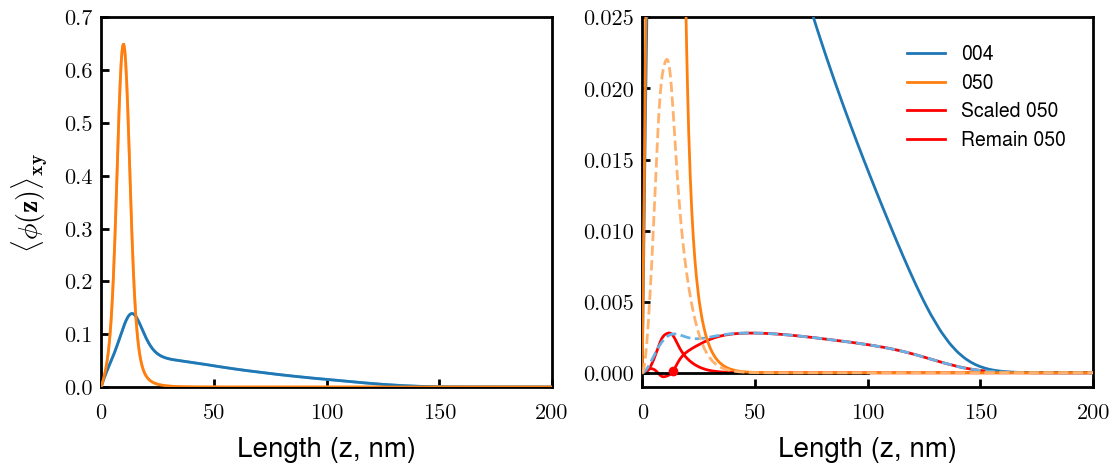

In [10]:
## TEST CELL
labs = ['004', '050'] 
read_list = [GIT+"phb2v20_c"+i+".dat" for i in labs]
fig, axs = tjy.plot_pha(read_list, b0=2.0, x1_end=200, y1_end=0.7, y2_end=0.025, labs=labs, block2=4, double=True, show=False)

df0 = pd.read_csv(read_list[0], sep="\s+", skiprows=0, names=['lx','pha', '_2', '_3', '1', '2', '3', '4', 'end', '_9', 'phb'])
df1 = pd.read_csv(read_list[1], sep="\s+", skiprows=0, names=['lx','pha', '_2', '_3', '1', '2', '3', '4', 'end', '_9', 'phb'])
b = pd.read_csv(read_list[-1], sep="\s+", skiprows=0, names=['lx','pha', '_2', '_3', '1', '2', '3', '4', 'end', '_9', 'phb'])

from scipy.interpolate import CubicSpline
x_new = np.linspace(0, 200, 1000)
f = CubicSpline(b.lx*2, b.end, bc_type=('not-a-knot', (1, 0)))
base = f(x_new)
scale = max(df0.end)/max(base)

def last_zero(rem1):
## Find last near-zero value in rem1
    A = np.nonzero(np.abs(rem1)<1e-04)[0]
    cA = [i for i in A[::-1]]
    for ind, i in enumerate(cA):
        try:
            if (cA[ind+1]-i == -1): continue
            else: start = A[len(A)-2-ind]; break
        except IndexError: 
            return 0
    return start

vals = np.arange(0.0, 5.00, 0.05)
ints = np.zeros(len(vals))
fints = np.zeros(len(vals))
for ind, shift in enumerate(vals):
    s = CubicSpline(x_new+shift, scale*base)
    s1 = s(x_new)
    f1 = CubicSpline(df0.lx*2, df0.end, bc_type=('not-a-knot', (1, 0)))
    rem1 = f1(x_new) - s1
    start = last_zero(rem1)
    ints[ind] = np.trapz(rem1[:start], x_new[:start]) ## Integral from 0 to start of coil region
    fints[ind]= np.trapz(rem1, x_new)  ## Integral of entire calculated coil profile
    
# display(pd.DataFrame([ints, fints], columns=vals).transpose())
# display(pd.DataFrame([ints, fints], columns=vals).transpose().loc[2.75])

if (min(np.abs(fints)) < 1e-04): # Negligible amount of coil 
    best = vals[np.nonzero(np.abs(fints)<1e-04)][0] # First value which meets criterion
    print(np.abs(fints))
else: 
    best = vals[np.nonzero(abs(ints)==min(np.abs(ints)))][0]
s = CubicSpline(x_new+best, scale*base)
s1 = s(x_new)
f1 = CubicSpline(df0.lx*2, df0.end, bc_type=('not-a-knot', (1, 0)))
rem1 = f1(x_new) - s1
start = last_zero(rem1)
print('x_shift: {:.2f}, int: {:.4e}'.format(best, np.trapz(rem1[:start], x_new[:start]))) ## Integral from 0 to start of coil region
    
axs[1].plot(x_new, s1,   c='r', label='Scaled 050')
axs[1].plot(x_new, rem1, c='r', label='Remain 050')
axs[1].scatter(x_new[start], rem1[start], c='r', zorder=10)
axs[1].plot([0, 100], [0,0], 'k')
axs[1].set_ylim((-0.001, 0.025))
axs[1].legend()
plt.show()

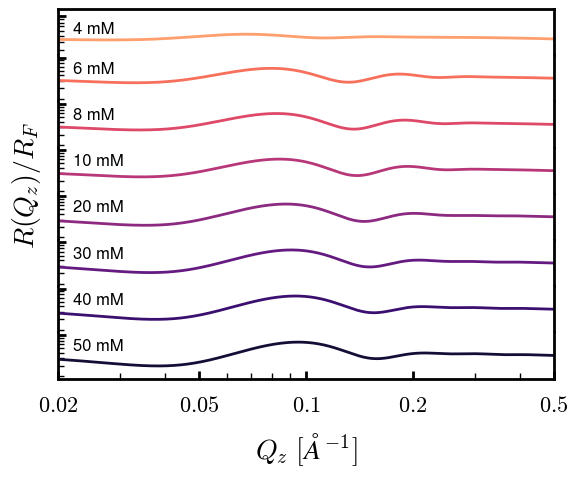

In [4]:
rho_e_w = 3.33e23 # electron density of water, e/cm3 (Source: Brasla, 1985)
rho_e_w *= 1e2**3 / 1e10**3 # e/AA3
r_e = 2.818e-15 # m
r_e *= 1e10 # AA

def RQZ_pha(phname, qz):
    ph = pd.read_csv(phname, sep="\s+", skiprows=0, header=None)
    pha = ph[2]
    pha.update(pd.Series([2.32], index=[0])) # electron density of SiO2 substrate, assuming polymer electron density 1.0: (CH2)x = 0.95 (Source: Russel, 1990)
    phb = ph[10]
    phe = pha*1.0 + phb*rho_e_w # electron density profile, rho_e_protein = 1.0
    z = ph[0]*10 # nm to AA
    dz = z[1] - z[0]
    dpdz = np.gradient(phe, dz)
    return [RQZ(z, dpdz, i) for i in qz]

def RQZ(z, dpdz, qzi): return np.power(np.absolute(np.trapz(dpdz*np.exp(1j*qzi*z), x=z)/rho_e_w), 2) # j is imaginary

def Z_PHA(phname):
    ph = pd.read_csv(phname, sep="\s+", skiprows=0, header=None)
    ph.iloc[0,1] = 10 # Artificial substrate with 5x electron density as polymer and solvent
    return ph.iloc[:,0:2] 

def RQZ_plot3(row, qz, filename, color,light_frac):
  laxs[row].plot(qz, RQZ_pha(filename, qz), color=color, alpha=1.0)
  return

qz = np.logspace(-3,0,1000) # 0.001 to 1
light_arr = np.linspace(1.0,1.0, 1)
f, laxs = plt.subplots(8,1)

labs = (4,6,8,10,20,30,40,50)
phs = ['phb2v2c1_c{:03d}.dat'.format(i) for i in labs]
cividis = mpl.colormaps['magma'].resampled(11)(range(8,0,-1))
for row, i in enumerate(cividis): 
    RQZ_plot3(row, qz, GIT+phs[row], i, light_arr[0])
    plt.sca(laxs[row]); plt.annotate('{} mM'.format(labs[row]), (0.022, 55), fontsize=12) 
    
for i in laxs:
  i.set_xscale('log')
  i.set_xlim([0.02, 0.50])
  i.set_xlim([0.02, 0.50])
  ticklabs = [0.02, 0.05, 0.1, 0.2, 0.5]
  i.set_xticks(ticklabs)
  i.set_xticklabels(['${}$'.format(i) for i in ticklabs])
  i.set_xticklabels([], minor=True)
  i.set_yscale('log')
  if i!=laxs[0]: i.set_ylim([18, 110])
  else: i.set_ylim([25, 130])
  i.tick_params(axis='y',which='both', labelleft=False)
  if i != laxs[-1]: 
    i.tick_params(axis='x', which='both', length=0.0, labelbottom=False)
    i.spines['bottom'].set_color('none')
  if i!= laxs[0]: 
    i.spines['top'].set_color('none')

plt.gcf().text(0.050, 0.40, r'$R(Q_z)/R_F$', 
               rotation=90, fontsize=20)
plt.subplots_adjust(hspace=0)
laxs[-1].set_xlabel(r'$Q_z$' ' ' r'$[\AA^{-1}]$')
plt.savefig('./imgs/refs.eps')
plt.show()

[4.820137006686982, 3.935625385563126, 3.048522315039426, 2.1556308015628907, 1.363340625470637]


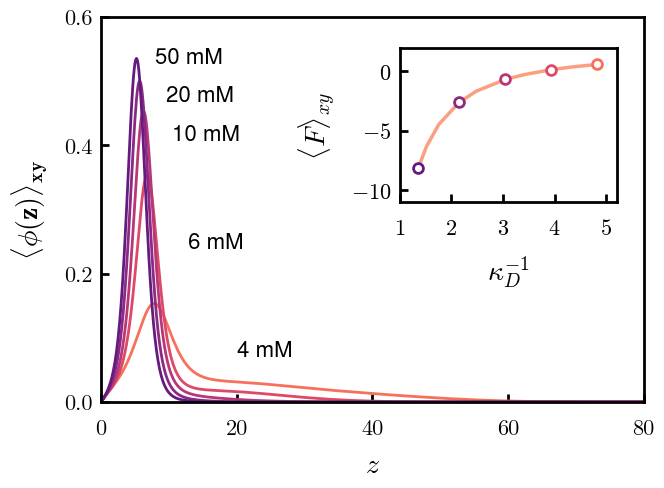

In [84]:
c1 = [122/255, 28/255, 188/255]
c2 = [252/255, 159/255, 128/255]

block1 = None
labs = ['004', '006', '010', '020', '050']
read_list = [GIT+"phf400_c"+i+".dat" for i in labs]
block_Ni = [[5]]*len(read_list)
             
# colors = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10']*5
colors = mpl.colormaps['magma'].resampled(11)(range(7, -1, -1))

fig, ax = plt.subplots(1,1, figsize=(7,5)) 

## PLOT INSET#################################################
axins = ax.inset_axes([0.55, 0.52, 0.40, 0.40])
df = pd.read_csv(GIT+'f400_pr.txt', sep='\s+', names=['it', 'lx', 'freeE', 'fDiff', 'inComp', 'andErr'])
marks = df.freeE[[True, False, True, False, True, False, True, False, False, True]]
xDeb = [1/tjy.Kap_D(i*1e-3)*1e9 for i in (4,5,6,8,10,15,20,30,40,50)]
xDeb2 = [1/tjy.Kap_D(i*1e-3)*1e9 for i in (4,6,10,20,50)]
print(xDeb2)
axins.plot(xDeb, df.freeE, '-', c=c2, lw=2.5, markerfacecolor='w', mew = 1.5, ms = 6)
for ind, i in enumerate(marks): axins.scatter(xDeb2[ind], i, s=50, color=colors[ind], linewidth=2.0, facecolor='w', zorder=3)
axins.set_xlim(1.0, 5.2)
axins.set_xticks([1,2,3,4,5])
axins.set_xlabel(r'$\kappa_D^{-1}$')
axins.set_ylim(-11, 2.0)
axins.set_ylabel(r'$\langle F \rangle_{xy}$')

class ScalarFormatterClass(ticker.ScalarFormatter):
   def _set_format(self):
      self.format = "$%d$" # New precision
axins.yaxis.set_major_formatter(ScalarFormatterClass(useMathText=True))
axins.xaxis.set_major_formatter(ScalarFormatterClass(useMathText=True))
        
## PLOT MAIN###########################################
for k in range(len(read_list)):
  block_Nik = block_Ni[k]
  a = 1
  b = 1
  c = 1
  names = ['rx', 'phA']
  for j in range(len(block_Nik)):
    names += ['phA_T{:d}'.format(a)] +  ['*'*b]+ ['ph{:d}'.format(c+i) for i in range(block_Nik[j])] + ['*'*(b+1)]
    a += 1
    b += 2
    c += block_Nik[j]

  names += ['phB']
  try: df = pd.read_csv(read_list[k], sep="\s+", skiprows=0, names=names)
  except HTTPError: 
      print('{} not found'.format(read_list[k]))
  Nx = len(df.index)

  for i in range(len(block_Nik)*2):
    names.remove('*'*(i+1))
    df = df.drop('*'*(i+1),axis=1)

  Nx = len(df.index)
  rows = range(0, Nx)

  rows = range(0, Nx)

  phAr = pd.DataFrame(data=None, index=rows, columns=range(2), dtype=None, copy=False)
  phAr = phAr.fillna(0) # with 0s rather than NaNs
  phAT = pd.DataFrame(data=None, index=rows, columns=range(1+len(block_Nik)), dtype=None, copy=False)
  phAT = phAT.fillna(0) # with 0s rather than NaNs
  ph1r = pd.DataFrame(data=None, index=rows, columns=range(1+sum(block_Nik)), dtype=None, copy=False)
  ph1r = ph1r.fillna(0) # with 0s rather than NaNs

  phB = pd.DataFrame(data=None, index=rows, columns=range(2), dtype=None, copy=False)
  phB = phB.fillna(0) # with 0s rather than NaNs

  ph1r = df.loc[:, ['ph{:d}'.format(i+1) for i in range(sum(block_Nik))]]
  ph1r.insert(0, 'rx', df.iloc[:,0])

  phAT = df.loc[:, ['phA_T{:d}'.format(i+1) for i in range(len(block_Nik))]]
  phAT.insert(0, 'rx', df.iloc[:,0])

  for i in range(Nx):
    phAr.iloc[i, 0] = df.iloc[i,0]
    phAr.iloc[i, 1] = df.iloc[i,1] 
    phB.iloc[i, 0] = df.iloc[i, 0]
    phB.iloc[i, 1] = df.iloc[i, 2 + sum(block_Nik) + len(block_Nik)] 

  lshi = pd.DataFrame(data=None,  index=rows, columns=range(1), dtype=None, copy=False)
  rshi = pd.DataFrame(data=None,  index=rows, columns=range(1), dtype=None, copy=False)

  # Plot total density (zorder 3)
  lshi[0] = phAr[0] + 0
  rshi[0] = phAr[0] + 0

  ax.plot(lshi[0], phAr.iloc[:,1], color = colors[k], zorder = 2, alpha=1.0, label=labs[k])

  # Plot chain types (zorder 2)
  step = 1
  for j in range(len(block_Nik)):

    #Plot block densities (zorder 3)
    for i in range(block_Nik[j]):
      if (i == block1): ax.plot(lshi[0], ph1r.iloc[:,i+step], ':',  zorder=2, color=tjy.lighten_color(colors[k], 0.60),label='_Block')

    step += block_Nik[j]

conf = [Patch(facecolor=i, edgecolor='k', lw=1.5) for i in colors]
conf += [
          Line2D([0], [0], color='k', ls='-'),
          Line2D([0], [0], color='k', ls='--'),
        ]
plt.ylabel(r'$\bf{\langle\phi(z)\rangle}_{xy}$')
plt.xlabel(r'$z$')
plt.ylim(0, 0.60)
plt.yticks(np.arange(0, 0.61, 0.2))
plt.xlim(0, 80)
plt.xticks(np.arange(0, 81, 20))
# leg = plt.legend(bbox_to_anchor=(1.00, 0.98), loc='upper right', title='b', title_fontproperties={'size':24}, alignment='left')
# plt.text(0.92, 0.88, 'b', fontsize=24, transform=ax.transAxes)
plt.text(0.10, 0.88, '50 mM', fontsize=16, transform=ax.transAxes)
plt.text(0.12, 0.78, '20 mM', fontsize=16, transform=ax.transAxes)
plt.text(0.13, 0.68, '10 mM', fontsize=16, transform=ax.transAxes)
plt.text(0.16, 0.40, '6 mM', fontsize=16,  transform=ax.transAxes)
plt.text(0.25, 0.12, '4 mM', fontsize=16,  transform=ax.transAxes)

tjy.ticks()
plt.savefig('./imgs/dens.eps')
plt.show()

297.5836209975003
104.04392507211409


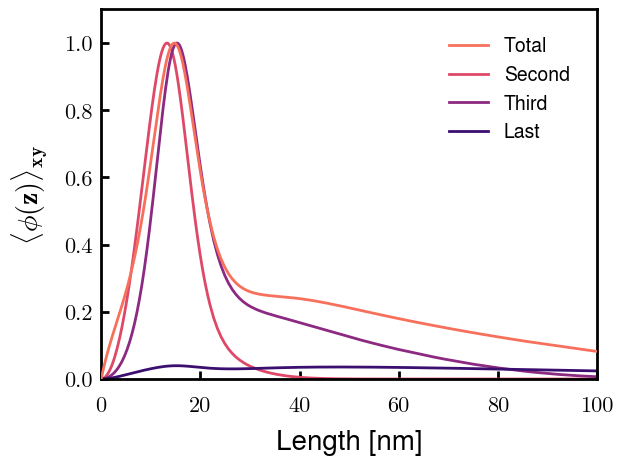

In [107]:
block1 = None
b0 = 2.2
labs = ['004']
read_list = [GIT+"phb2v2c1_c"+i+".dat" for i in labs]
block_Ni = [[5]]*len(read_list)
             
div = [b0]*len(read_list) #b0
# colors = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10']*5
colors = mpl.colormaps['magma'].resampled(11)(range(7, -1, -1))

fig, AX = plt.subplots(1,1) 
for k in range(len(read_list)):
  block_Nik = block_Ni[k]
  a = 1
  b = 1
  c = 1
  names = ['rx', 'phA']
  for j in range(len(block_Nik)):
    names += ['phA_T{:d}'.format(a)] +  ['*'*b]+ ['ph{:d}'.format(c+i) for i in range(block_Nik[j])] + ['*'*(b+1)]
    a += 1
    b += 2
    c += block_Nik[j]

  names += ['phB']
  try: df = pd.read_csv(read_list[k], sep="\s+", skiprows=0, names=names)
  except HTTPError: 
      print('{} not found'.format(read_list[k]))
  Nx = len(df.index)

  for i in range(len(block_Nik)*2):
    names.remove('*'*(i+1))
    df = df.drop('*'*(i+1),axis=1)

  Nx = len(df.index)
  rows = range(0, Nx)

  rows = range(0, Nx)

  phAr = pd.DataFrame(data=None, index=rows, columns=range(2), dtype=None, copy=False)
  phAr = phAr.fillna(0) # with 0s rather than NaNs
  phAT = pd.DataFrame(data=None, index=rows, columns=range(1+len(block_Nik)), dtype=None, copy=False)
  phAT = phAT.fillna(0) # with 0s rather than NaNs
  ph1r = pd.DataFrame(data=None, index=rows, columns=range(1+sum(block_Nik)), dtype=None, copy=False)
  ph1r = ph1r.fillna(0) # with 0s rather than NaNs

  phB = pd.DataFrame(data=None, index=rows, columns=range(2), dtype=None, copy=False)
  phB = phB.fillna(0) # with 0s rather than NaNs

  ph1r = df.loc[:, ['ph{:d}'.format(i+1) for i in range(sum(block_Nik))]]
  ph1r.insert(0, 'rx', df.iloc[:,0])

  phAT = df.loc[:, ['phA_T{:d}'.format(i+1) for i in range(len(block_Nik))]]
  phAT.insert(0, 'rx', df.iloc[:,0])

  for i in range(Nx):
    phAr.iloc[i, 0] = df.iloc[i,0]
    phAr.iloc[i, 1] = df.iloc[i,1] 
    phB.iloc[i, 0] = df.iloc[i, 0]
    phB.iloc[i, 1] = df.iloc[i, 2 + sum(block_Nik) + len(block_Nik)] 

  lshi = pd.DataFrame(data=None,  index=rows, columns=range(1), dtype=None, copy=False)
  rshi = pd.DataFrame(data=None,  index=rows, columns=range(1), dtype=None, copy=False)

  # Plot total density (zorder 3)
  lshi[0] = phAr[0] + 0
  rshi[0] = phAr[0] + 0

  plt.plot(np.multiply(lshi[0], div[k]), phAr.iloc[:,1]/np.max(phAr.iloc[:,1]), color = colors[0], zorder = 3, label='Total')

  # Plot chain types (zorder 2)
  step = 1
  for j in range(len(block_Nik)):
    # ax.plot(np.multiply(lshi[0], div[k]), phAT.iloc[:,j+1], '-',  zorder=2, color=tjy.lighten_color(colors[k], amount=0.50),label='_Total')

    #Plot block densities (zorder 3)
    for i in range(block_Nik[j]):
      if (i == 1): plt.plot(np.multiply(lshi[0], div[k]), ph1r.iloc[:,i+step]/np.max(ph1r.iloc[:,i+step]), '-',  zorder=2, color=tjy.lighten_color(colors[1], 1.00),label='Second')
      if (i == 2): plt.plot(np.multiply(lshi[0], div[k]), ph1r.iloc[:,i+step]/np.max(ph1r.iloc[:,i+step]), '-',  zorder=2, color=tjy.lighten_color(colors[3], 1.00),label='Third')
      norm1 = 1/np.max(ph1r.iloc[:,i+step])
      if (i == 4): 
            peak = 115
            norm2 = phAr.iloc[peak,1]/ph1r.iloc[peak,i+step]/np.max(phAr.iloc[:,1])
            plt.plot(np.multiply(lshi[0], div[k]), ph1r.iloc[:,i+step]*norm, '-',  zorder=2, color=tjy.lighten_color(colors[5], 1.00),label='Last')

    step += block_Nik[j]

conf = [Patch(facecolor=i, edgecolor='k', lw=1.5) for i in colors]
conf += [
          Line2D([0], [0], color='k', ls='-'),
          Line2D([0], [0], color='k', ls='--'),
        ]

# tjy.ticks(axs)

# plt.text(0.92, 0.88, 'a', fontsize=24, transform=axs[0].transAxes)
AX.set_ylabel(r'$\bf{\langle\phi(z)\rangle}_{xy}$')
AX.set_xlabel("Length [nm]")
AX.set_ylim(0, 1.10)
# axs[0].set_yticks(np.arange(0, 0.031, 0.01))
AX.set_xlim(0, 100)

# plt.text(0.92, 0.88, 'b', fontsize=24, transform=axs[1].transAxes)
# axs[1].set_ylabel(r'$\bf{\langle\phi(z)\rangle}_{xy}$')
# axs[1].set_xlabel("Length [nm]")
# axs[1].set_ylim(0, 0.08)
# axs[1].set_yticks(np.arange(0, 0.081, 0.02))
# axs[1].set_xlim(0, 200)
# axs[1].set_xticks(np.arange(0, 201, 50))
print(norm1)
print(norm2)
custom_legend = [Line2D([0], [0], color=i, ls ='-', lw=2) for i in colors]
xDeb2 = ['{:.2f} nm'.format(1/tjy.Kap_D(i*1e-3)*1e9) for i in (4,6,8,10,20,50)]
plt.legend()
tjy.ticks()

plt.savefig('./imgs/blocki.eps')
plt.show()